# Structure Discovery based on Cliques

Updated on 2020-02-26

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cliques_discovery import *
from helpers import *

## Overview

The goal of the method is to find a control flow graph (see Allen, 1970, "Control Flow Analysis") that partially describes the process behind a set of logs, i.e., a collection of sequence of events. The method is based on a constructive approach adding examples in which:

```
(For each trace)
1. Calculate all successors only for this trace
2. Build the associated unentangled DAG and remove the loops
3. Combine with previous unentangled DAGs
4. Minimize all DAGs and recover loops info
```

And at the end, once all the examples has been used the information of the loops are ingested back to the resulting graph.

## Method for control flow discovery using cliques

Sketch of the method

In [3]:
# Be a "trace" a sequence over a finite alphabet A
# Be T a collection of traces on A
def cliques_discovery(T):
    
    DAG_allTraces = None # Void graph
    all_loops = {}       # No sequences
    
    for trace in T:

        # --------------------------------------------
        # (1) Calculate the successors (u,v_0), (u, v_1) ...  only for this trace, 
        # --------------------------------------------        
        # (1.1) Get successors and count its frequency
        succ_f = get_successor_by_freq([trace])

        # (1.2) Create the graph of successors, with edges weighted with its frequency (u, v, freq)
        succ_G = successorsGraph( succ_f )

        # --------------------------------------------
        # (2) Build the associated unentangled DAG and remove the loops
        # --------------------------------------------
        # (2.1) using cliques, detect all longest single paths [u_0, u_1, ..., u_m]
        paths_this_trace = infer_paths( split_in_freqGraphs(  succ_G  ) )

        # (2.2) Detect and remove loops (saving for later) by computing raw paths that behaves as loops and return associated DAG.
        loops_this_trace, succ_DAG = remove_loops_in_trace(paths_this_trace, succ_G)
        
        # (2.3) Add loops found in this pair to the loops in all traces
        all_loops = remember_loops( loops_this_trace, all_loops )
        
        # (2.4) Unentanglement. The graph should be now 1-cycle free. So, let's remove any parasite 1-cycle (u,v) (v,u) still in succ_DAG!
        succ_DAG_unentangled = unentangled_DAG( succ_DAG )
        
        # --------------------------------------------
        # (3) Combine with previous unentangled DAGs
        # --------------------------------------------
        DAG_allTraces = combine_DAGs(succ_DAG_unentangled, DAG_allTraces)

    # --------------------------------------------
    # (4) Minimize all DAGs and recover loops info
    # --------------------------------------------

    # (4.1) Extract single paths using cliques. Note that this is the same than step (2.1)
    single_paths = infer_paths( split_in_freqGraphs( DAG_allTraces ) )
    
    # (4.2) Build the graph of paths and minimize it: if paths (u,z,v) and (u,v) exists, leave just (u,z,v)
    G = minimally_connected( path_graph( single_paths ) )
    
    # (4.3) Recover loops info , perhaps based on some threshold...
    # PENDING!!
    
    return single_paths, all_loops, G


## Results

### Simple examples

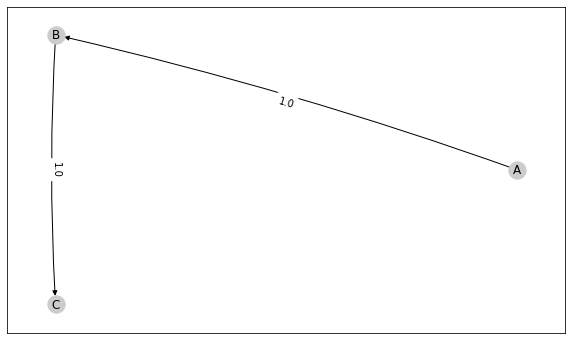

Paths: 
 {1.0: [['A', 'B', 'C']]}
Loops: 
 {}


In [7]:
# Single path ABC
T = [list("ABC")]
pretty ( cliques_discovery(T) )

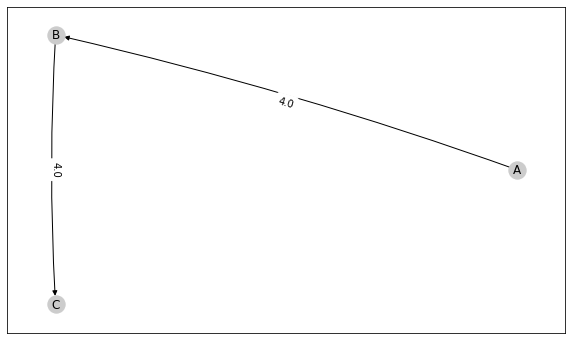

Paths: 
 {4.0: [['A', 'B', 'C']]}
Loops: 
 {('A', 'B', 'C'): 4.0}
CPU times: user 589 ms, sys: 57 ms, total: 646 ms
Wall time: 259 ms


In [18]:
# Loop ABC
T = [list("ABCABCABCABC")]
%time pretty ( cliques_discovery(T) )

### Combined single paths and loops

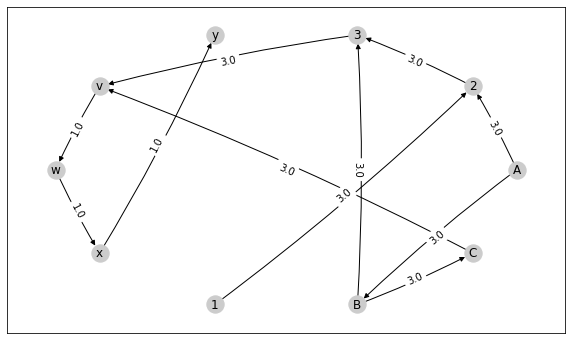

Paths: 
 {1.0: [['v', 'w', 'x', 'y']], 3.0: [['A', '2', '3', 'y'], ['A', '2', '3', 'v'], ['A', '2', '3', 'w'], ['A', '2', '3', 'x'], ['1', '2', '3', 'y'], ['1', '2', '3', 'v'], ['1', '2', '3', 'w'], ['1', '2', '3', 'x'], ['A', 'B', '3', 'y'], ['A', 'B', '3', 'v'], ['A', 'B', '3', 'w'], ['A', 'B', '3', 'x'], ['A', 'B', 'C', 'y'], ['A', 'B', 'C', 'v'], ['A', 'B', 'C', 'w'], ['A', 'B', 'C', 'x']]}
Loops: 
 {('A', '2', '3'): 3.0, ('1', '2', '3'): 3.0, ('A', 'B', '3'): 3.0, ('A', 'B', 'C'): 3.0}
CPU times: user 653 ms, sys: 55.5 ms, total: 708 ms
Wall time: 325 ms


In [17]:
# Loops: "ABC", "123", s-path: "vwxy"
T = [list("ABC1231A2B3C1ABC23vwxy")]
%time pretty ( cliques_discovery(T) )

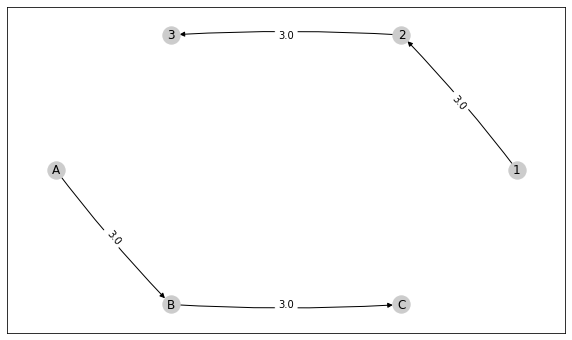

Paths: 
 {3.0: [['1', '2', '3'], ['A', 'B', 'C']]}
Loops: 
 {('1', '2', '3'): 3.0, ('A', 'B', 'C'): 3.0}
CPU times: user 600 ms, sys: 58.4 ms, total: 658 ms
Wall time: 276 ms


In [16]:
#  Loops ABC, 123
T = [
    list(".1A.B2.C3..ABC...A1..2B..3C.123")
]
%time pretty ( cliques_discovery(T) )

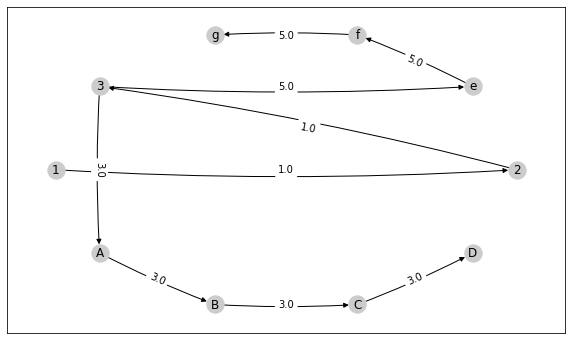

Paths: 
 {1.0: [['1', '2', '3']], 3.0: [['2', 'A', 'B', 'C', 'D'], ['3', 'A', 'B', 'C', 'D'], ['1', 'A', 'B', 'C', 'D']], 5.0: [['2', 'e', 'f', 'g'], ['3', 'e', 'f', 'g'], ['1', 'e', 'f', 'g']]}
Loops: 
 {('A', 'B', 'C', 'D'): 3.0, ('e', 'f', 'g'): 5.0}
CPU times: user 641 ms, sys: 54.2 ms, total: 695 ms
Wall time: 309 ms


In [25]:
"""
head_with_loop = 123 ABCD* efg*

12 @ABCD @ef
"""
T = [
    list("123ABCDefgABCDABCDefgefgefgefg")
]
%time pretty ( cliques_discovery(T) )

### Multiple Traces

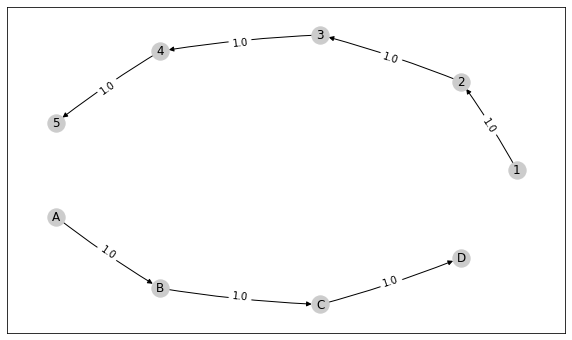

Paths: 
 {1.0: [['1', '2', '3', '4', '5'], ['A', 'B', 'C', 'D']]}
Loops: 
 {}
CPU times: user 679 ms, sys: 52.8 ms, total: 732 ms
Wall time: 342 ms


In [27]:
T = [
    list("ABCD"),
    list("12345")
]
%time pretty ( cliques_discovery(T) )

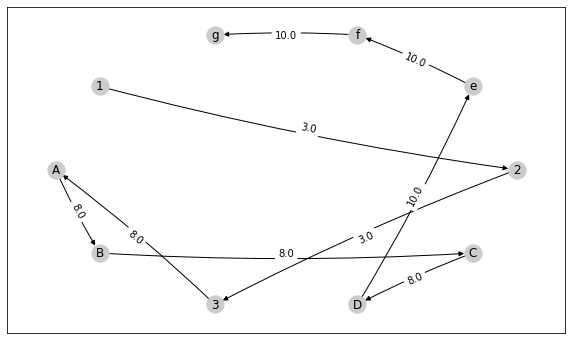

Paths: 
 {8.0: [['2', 'A', 'B', 'C', 'D'], ['3', 'A', 'B', 'C', 'D'], ['1', 'A', 'B', 'C', 'D']], 10.0: [['2', 'e', 'f', 'g'], ['1', 'e', 'f', 'g'], ['A', 'e', 'f', 'g'], ['B', 'e', 'f', 'g'], ['3', 'e', 'f', 'g'], ['D', 'e', 'f', 'g'], ['C', 'e', 'f', 'g']], 3.0: [['1', '2', '3']]}
Loops: 
 {('A', 'B', 'C', 'D'): 8.0, ('e', 'f', 'g'): 10.0}
CPU times: user 647 ms, sys: 56 ms, total: 703 ms
Wall time: 323 ms


In [26]:
"""
head_with_loop = 123 ABCD* efg*

12 @ABCD @ef
"""
T = [
    list("123ABCDefgABCDABCDefgefgefgefg"),
    list("123ABCDABCDefgefgefgefgefg"),
    list("123ABCDABCDABCD")
]
%time pretty ( cliques_discovery(T) )

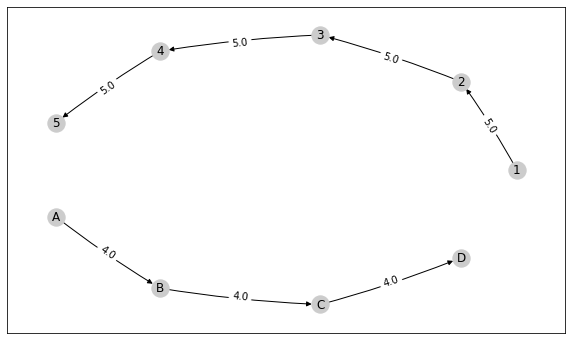

Paths: 
 {4.0: [['A', 'B', 'C', 'D']], 5.0: [['1', '2', '3', '4', '5']]}
Loops: 
 {('A', 'B', 'C', 'D'): 2.0, ('A', 'B', 'C', 'D', '1', '2', '3', '4', '5'): 2.0, ('1', '2', '3', '4', '5'): 3.0}
CPU times: user 623 ms, sys: 52.9 ms, total: 676 ms
Wall time: 291 ms


In [28]:
T = [
    list("ABCDABCD"),
    list("ABCD12345ABCD12345"),
    list("123451234512345")
]
%time pretty ( cliques_discovery(T) )

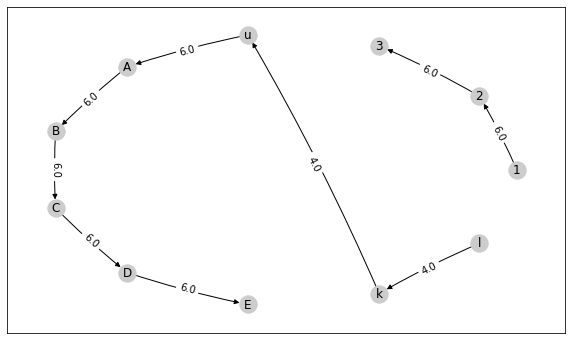

Paths: 
 {4.0: [['l', 'k', 'u']], 6.0: [['1', '2', '3'], ['u', 'A', 'B', 'C', 'D', 'E'], ['k', 'A', 'B', 'C', 'D', 'E'], ['l', 'A', 'B', 'C', 'D', 'E']]}
Loops: 
 {('l', 'k', 'u'): 2.0, ('A', 'B', 'C', 'D', 'E'): 5.0, ('u', 'A', 'B', 'C', 'D', 'E'): 3.0, ('k', 'A', 'B', 'C', 'D', 'E'): 3.0, ('l', 'A', 'B', 'C', 'D', 'E'): 3.0, ('1', '2', '3'): 4.0}
CPU times: user 649 ms, sys: 51 ms, total: 700 ms
Wall time: 311 ms


In [29]:
# combined_loops: lk 12 ABCDE
T = [
    list("lkulku123123ABCDEABCDEABCDE123123"),
    list("lku123ABCDEABCDE"),
    list("lku123ABCDE"),
]
%time pretty ( cliques_discovery(T) )

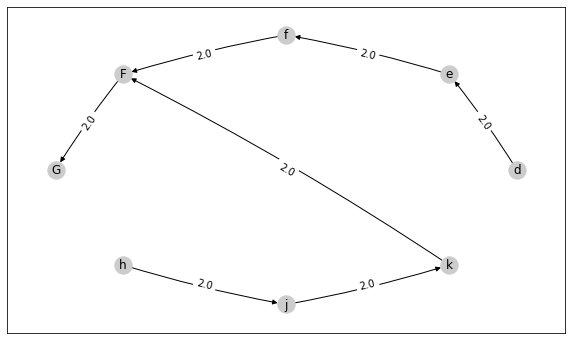

Paths: 
 {2.0: [['d', 'e', 'f', 'F', 'G'], ['h', 'j', 'k', 'F', 'G']]}
Loops: 
 {('d', 'e', 'f'): 2.0, ('h', 'j', 'k'): 2.0}
CPU times: user 613 ms, sys: 51.6 ms, total: 664 ms
Wall time: 279 ms


In [30]:
"""
  @def 
       > FG 
  @hjk 
"""        
T = [
    list("defdefFG"),
    list("hjkhjkFG")
]
%time pretty ( cliques_discovery(T) )

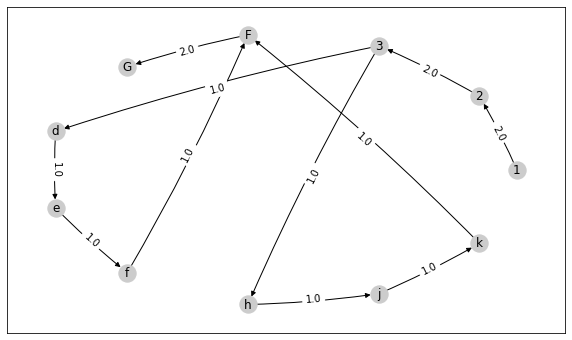

Paths: 
 {1.0: [['2', 'd', 'e', 'f'], ['d', 'e', 'f', 'G'], ['d', 'e', 'f', 'F'], ['1', 'd', 'e', 'f'], ['3', 'd', 'e', 'f'], ['2', 'h', 'j', 'k'], ['h', 'j', 'k', 'G'], ['h', 'j', 'k', 'F'], ['1', 'h', 'j', 'k'], ['3', 'h', 'j', 'k']], 2.0: [['1', '2', '3', 'F', 'G']]}
Loops: 
 {}
CPU times: user 661 ms, sys: 58.6 ms, total: 719 ms
Wall time: 333 ms


In [32]:
"""
        hjk
  123 <     > FG
        def 
"""
T = [
    list("123defFG"),
    list("123hjkFG")
]
%time pretty ( cliques_discovery(T) )

### Interleaved

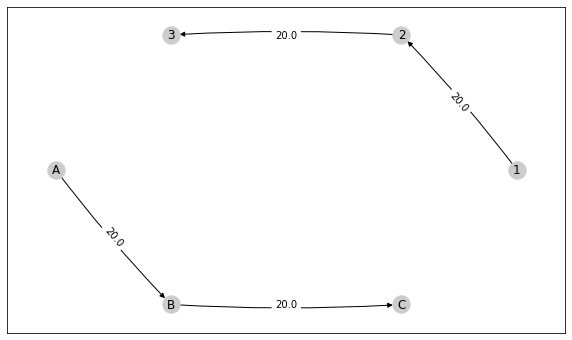

Paths: 
 {20.0: [['1', '2', '3'], ['A', 'B', 'C']]}
Loops: 
 {}
CPU times: user 603 ms, sys: 54.3 ms, total: 658 ms
Wall time: 274 ms


In [34]:
"""
   ABC * 123        
"""
T = [ list(a) for a in ['ABC123', 'AB1C23', 'AB12C3', 'AB123C', 'A1BC23', 'A1B2C3', 'A1B23C', 
      'A12BC3', 'A12B3C', 'A123BC', '1ABC23', '1AB2C3', '1AB23C', '1A2BC3', 
      '1A2B3C', '1A23BC', '12ABC3', '12AB3C', '12A3BC', '123ABC'
]]
%time pretty ( cliques_discovery(T) )

### Some problems below... 2020-02-26

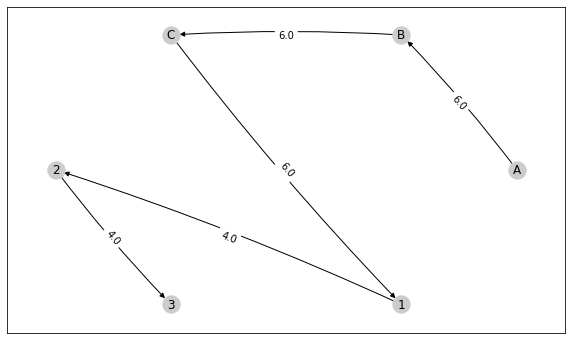

Paths: 
 {4.0: [['1', '2', '3']], 6.0: [['A', 'B', 'C', '2'], ['A', 'B', 'C', '3'], ['A', 'B', 'C', '1']]}
Loops: 
 {('1', '2', '3'): 4.0, ('A', 'B', 'C'): 6.0, ('2', 'A', 'B', 'C'): 3.0, ('3', 'A', 'B', 'C'): 3.0, ('1', 'A', 'B', 'C'): 3.0}
CPU times: user 608 ms, sys: 54 ms, total: 662 ms
Wall time: 277 ms


In [33]:
T = [
    list("123123ABCABCABC"),
    list("ABCABCABC123123")
]
%time pretty ( cliques_discovery(T) )